This assignment is inspired by: 

- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [2]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv('playground-series-s3e6/train.csv',index_col=0)
test_data  = pd.read_csv('playground-series-s3e6/test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [3]:
train_data_numeric = train_data.select_dtypes(include='number')
test_data_numeric = test_data.select_dtypes(include='number')

In [4]:
train_data_numeric.isna().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [5]:
test_data_numeric.isna().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
dtype: int64

In [7]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

X_train = train_data_numeric.drop(columns=['price'])
y_train = train_data_numeric['price']

# Initialize a list to store the names of selected features
selected_features = []

# Method 1: SelectKBest using F-statistic
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X_train, y_train)
selected_features.extend(X_train.columns[selector.get_support()])

# Method 2: SelectKBest using Mutual Information
selector = SelectKBest(score_func=mutual_info_regression, k=10)
X_new = selector.fit_transform(X_train, y_train)
selected_features.extend(X_train.columns[selector.get_support()])

# Method 3: Recursive Feature Elimination (RFE) with Random Forest
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=10)
X_new = selector.fit_transform(X_train, y_train)
selected_features.extend(X_train.columns[selector.support_])

# Method 4: Recursive Feature Elimination (RFE) with Linear Regression
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=10)
X_new = selector.fit_transform(X_train, y_train)
selected_features.extend(X_train.columns[selector.support_])

# Remove duplicates if any
selected_features = list(set(selected_features))

# Print the names of the final selected features
print("Selected Features:")
print(selected_features)

Selected Features:
['attic', 'squareMeters', 'cityCode', 'floors', 'isNewBuilt', 'hasStormProtector', 'cityPartRange', 'garage', 'numPrevOwners', 'basement', 'numberOfRooms', 'made', 'hasGuestRoom', 'hasYard', 'hasPool', 'hasStorageRoom']


In [8]:
X_train = X_train[selected_features]
X_test = test_data_numeric[selected_features]

### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [9]:
#Replacing the Year the home was built with Age

from datetime import datetime
current_year = datetime.now().year

for df in (X_train, X_test):
    # Calculate the "Age" column by subtracting "YearBuilt" from the current year
    df['Age'] = current_year - df['made']

/var/folders/hv/bb146n9d0yv30b1xnd05pwcr0000gn/T/ipykernel_3196/16618403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'] = current_year - df['made']


In [10]:
X_train.drop('made', axis=1, inplace=True)
X_test.drop('made', axis=1, inplace=True)

For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [11]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

Can you use grid search to find the optimal hyper parameters?

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define a custom RMSLE scorer function
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Create the RMSLE scorer for Grid Search
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
                   
# Create the Grid Search object
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring=rmsle_scorer, verbose=1)

# Fit the Grid Search to your data
grid_search.fit(X_train, y_train)  # Replace X and y with your features and target variable

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best estimator (model with the best hyperparameters)
best_estimator = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/var/folders/hv/bb146n9d0yv30b1xnd05pwcr0000gn/T/ipykernel_3196/4001271607.py:6: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
/var/folders/hv/bb146n9d0yv30b1xnd05pwcr0000gn/T/ipykernel_3196/4001271607.py:6: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
/var/folders/hv/bb146n9d0yv30b1xnd05pwcr0000gn/T/ipykernel_3196/4001271607.py:6: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
/var/folders/hv/bb146n9d0yv30b1xnd05pwcr0000gn/T/ipykernel_3196/4001271607.py:6: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


In [13]:
print("The best hyperparameters are ",grid_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700}


Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [14]:
best_regressor = best_estimator.fit(X_train, y_train)

Finally, can you run it on your test set?

In [15]:
y_pred = best_regressor.predict(X_test)

Can you score your solution offline and see how it does? - no?  There is no solution file that i can see

In [34]:
# read in the ground truth file
solution   = pd.read_csv(<your solution file>)
y_true     = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

SyntaxError: invalid syntax (907894919.py, line 2)

Finally, use the below block to prepare your submission

In [16]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":y_pred})
output.to_csv('submission2.csv', index=False)

### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

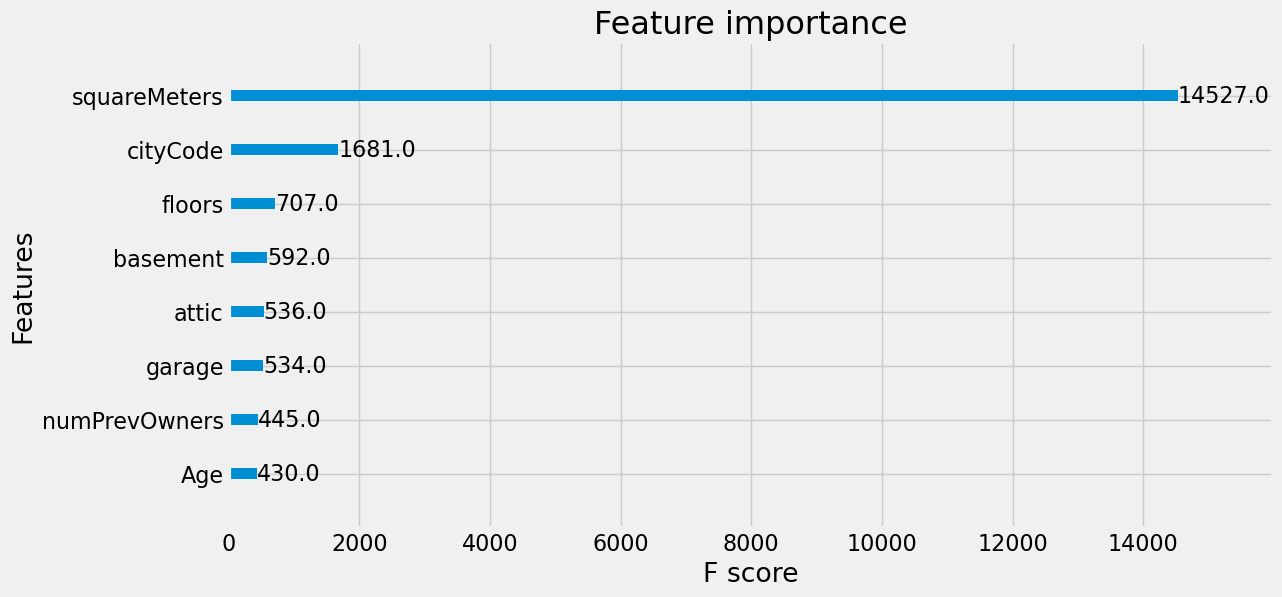

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(best_regressor, max_num_features=8, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


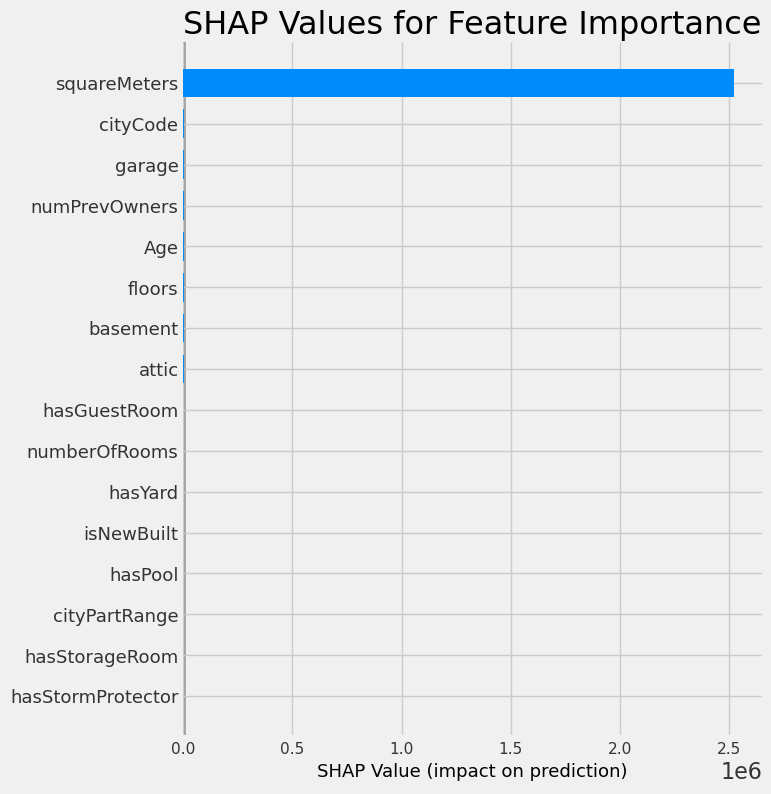

In [18]:
import shap
# Assuming you have a trained XGBoost model called 'best_regressor'
explainer = shap.Explainer(best_regressor)
shap_values = explainer.shap_values(X_test)  

# Summarize the SHAP values
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

# Add labels and customize the plot
plt.title('SHAP Values for Feature Importance')
plt.xlabel('SHAP Value (impact on prediction)')
plt.show()

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [19]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

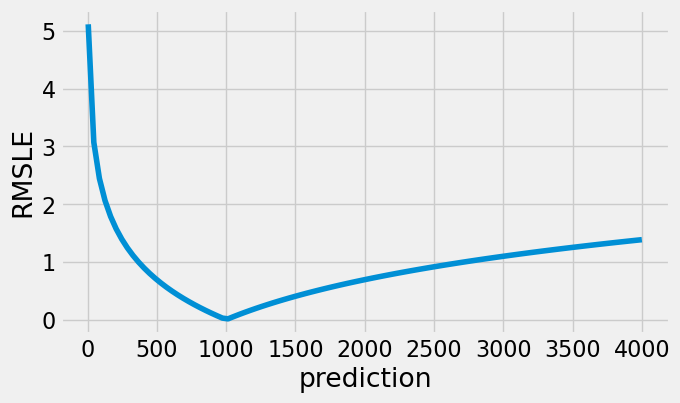

In [20]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()